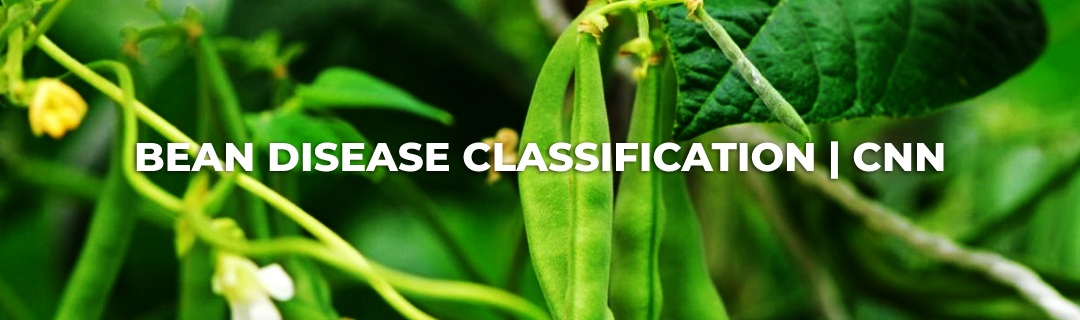

# 1. Importing Libraries And Data Augmentation
<h4 style="background-color:#1a4d08;color:white; padding:12px">1.1. IMPORTING LIBRARIES AND DEPENDENCIES</h4>

In [ ]:
%matplotlib inline

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import load_model

import os

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


2022-12-01 21:42:55.107104: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 21:42:55.108090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-01 21:42:55.209386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 21:42:55.210475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-12-01 21:42:55.210553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-01 21:42:55.215291: I tensorflow/stream_executor/platform/

<h4 style="background-color:#1a4d08;color:white; padding:12px">1.2. Data Augmentation</h4>

In [3]:
import cv2
import albumentations as A
import glob

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [4]:
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.6),
    ])

categories = ['angular_leaf_spot', 'bean_rust', 'healthy']

for cat in categories:
    for f in glob.glob('Bean_Dataset/'+cat+'/*'):
        for i in range(2):
            image = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
            path = 'Bean_Dataset/'+ cat + "/" + f.split("/")[-1].split(".")[0] +"_aug" + str(i) + "." + f.split("/")[-1].split(".")[-1]
            augmented_image = transform(image=image)['image']
            cv2.imwrite(path, augmented_image)

# 2. Loading And Visualizing the Data

<h4 style="background-color:#1a4d08;color:white; padding:12px">2.1. LOADING DATA</h4>

To load the images, I will use the Tensorflow tf.Data api which allows us to build a data input pipeline. 

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Bean_Dataset",  #folder name
    seed=85,
    # To randomly shuffle all the images
    shuffle=True,
    # Input image size
    image_size=(256, 256),
    # Set batch size to 32
    batch_size=32
)

Found 2970 files belonging to 3 classes.


2022-12-01 21:43:46.437273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 21:43:46.437644: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 21:43:46.437822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 21:43:46.438300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.2

In [7]:
bean_classes = dataset.class_names
bean_classes

['angular_leaf_spot', 'bean_rust', 'healthy']

**Summary**<br>
Our dataset contains 2970 files belonging to three classes:<br>
**`angular_leaf_spot`**,<br>
**`bean_rust`**, and<br>
**`healthy`**.

<h4 style="background-color:#1a4d08;color:white; padding:12px">2.2. DATA VISUALIZATION</h4>

Let's have a quick look at some of our images.

2022-12-01 21:43:47.306689: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-01 21:43:47.325796: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


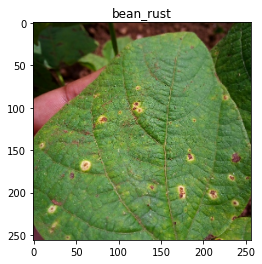

In [8]:
# Printing an image
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(bean_classes[labels_batch[0]])

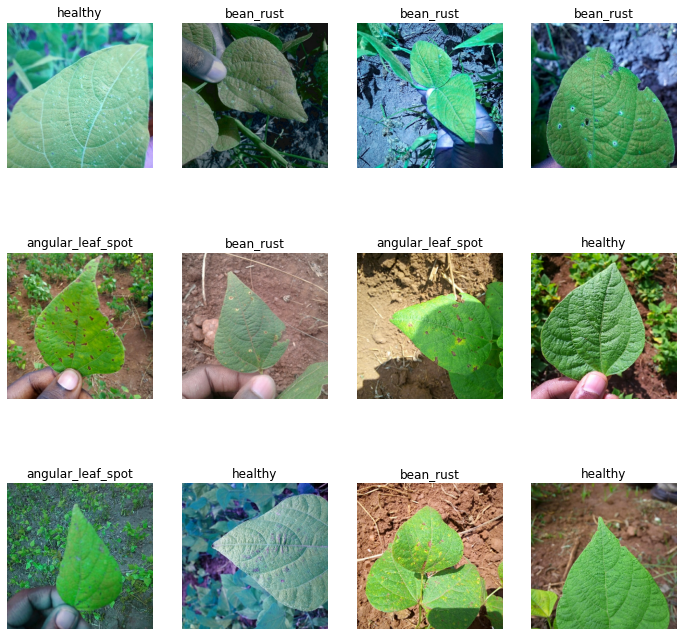

In [9]:
# First 12 images in the a batch
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

Let's see another batch of 12 images.

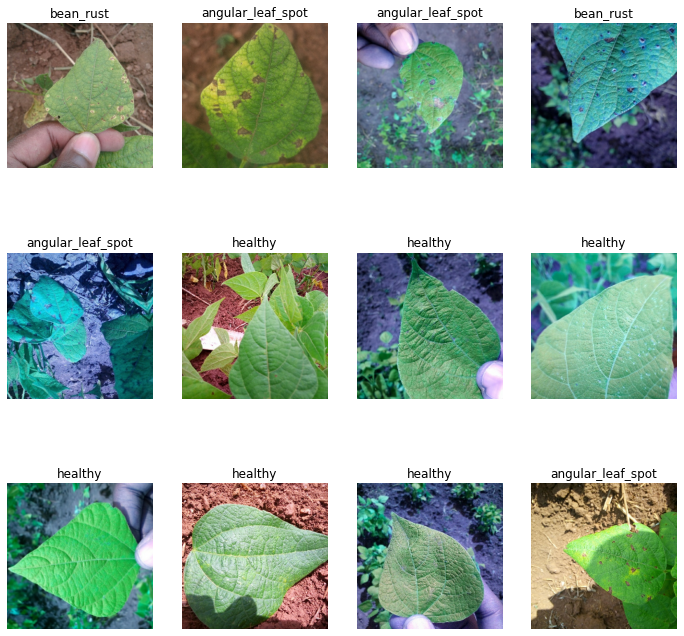

In [10]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

# 3. Split Dataset Into Train, Test, and Validation Sets

In [11]:
len(dataset)

93

There are a total of 93 batches in our dataset.<br>
Out of the 31 batches, we will keep 80% as our training data.<br>
From the remaining 20%, 10% will be the validation set, which will be used in the training process. We will keep another 10% as the test set.

<h4 style="background-color:#1a4d08;color:white; padding:12px">3.1. HELPER FUNCTION TO SPLIT OUR DATA</h4>

Let's write a helper function that will split our data into train, validation, and test sets.

In [12]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    """
    Takes a dataset and splits it into train, validation and test sets. 
    """
    dataset_size = len(dataset)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_set = dataset.take(train_size)    
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set

In [13]:
train_set, val_set, test_set = get_dataset_partitions_tf(dataset)

In [14]:
# Visualize the lenght of our splits
len(train_set), len(val_set), len(test_set)

(74, 9, 10)

**Train Set** = 74 batches<br>
**Validation set** = 9 batches<br>
**Test Set** = 10 batches

# 4. Configuring the Dataset for Better Performance
We will configure our dataset for better performance using the buffer prefetch, shuffling and cache method. We are going to do this for the train, validation and test splits.

* **Prefetching** helps minimize the step time to the maximum of the training and the time it takes to extract the data.
* **Caching** helps cache a dataset, either in memory or on local storage, which helps save some operations like file opening and data reading from being executed during epoch. **[Reference](https://www.tensorflow.org/guide/data_performance)**.

In [15]:
print("Configuring the dataset for better performance")
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Configuring the dataset for better performance


# 5. Modeling

<h4 style="background-color:#1a4d08;color:white; padding:12px">5.1. BUILD THE MODEL</h4>

For this we'll use the convolutional neural network (CNN). In building this model, we will pass a couple of layers: `resize_and_rescale`, `data_augmentation`, `Conv2D`, `Maxpooling2D`, `Flatten`, and `Dense` layers.

In [34]:
input_shape = (256, 256, 3)
n_classes = 3

model = models.Sequential()

model.add(Conv2D(16,(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16,(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16,(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)       

<h4 style="background-color:#1a4d08;color:white; padding:12px">5.2. COMPILE THE MODEL</h4>

We'll use the `adam` optimizer. And then define the `loss` and `accuracy` metrics in each epoch.

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

<h4 style="background-color:#1a4d08;color:white; padding:12px">5.3. FIT THE MODEL</h4>

In [36]:
history = model.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=30,
)

Epoch 1/30
24/24 [==============================] - 9s 377ms/step - loss: 6.0447 - accuracy: 0.3480 - val_loss: 1.0303 - val_accuracy: 0.4479
Epoch 2/30
24/24 [==============================] - 9s 378ms/step - loss: 0.9883 - accuracy: 0.5239 - val_loss: 0.9341 - val_accuracy: 0.5208
Epoch 3/30
24/24 [==============================] - 9s 380ms/step - loss: 0.9227 - accuracy: 0.5438 - val_loss: 0.8328 - val_accuracy: 0.6354
Epoch 4/30
24/24 [==============================] - 9s 377ms/step - loss: 0.9026 - accuracy: 0.5611 - val_loss: 0.9048 - val_accuracy: 0.5521
Epoch 5/30
24/24 [==============================] - 9s 386ms/step - loss: 0.8478 - accuracy: 0.6105 - val_loss: 0.9176 - val_accuracy: 0.5729
Epoch 6/30
24/24 [==============================] - 9s 387ms/step - loss: 0.8497 - accuracy: 0.5961 - val_loss: 0.8444 - val_accuracy: 0.6458
Epoch 7/30
24/24 [==============================] - 9s 385ms/step - loss: 0.7204 - accuracy: 0.6853 - val_loss: 0.7533 - val_accuracy: 0.7083
Epoch 

In [37]:
scores = model.evaluate(test_set)

4/4 [==============================] - 0s 80ms/step - loss: 0.2720 - accuracy: 0.9375


In [38]:
scores

[0.2720335125923157, 0.9375]

<h4 style="background-color:#1a4d08;color:white; padding:12px">5.4. PLOT ACCURACY AND LOSS CURVE</h4>

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

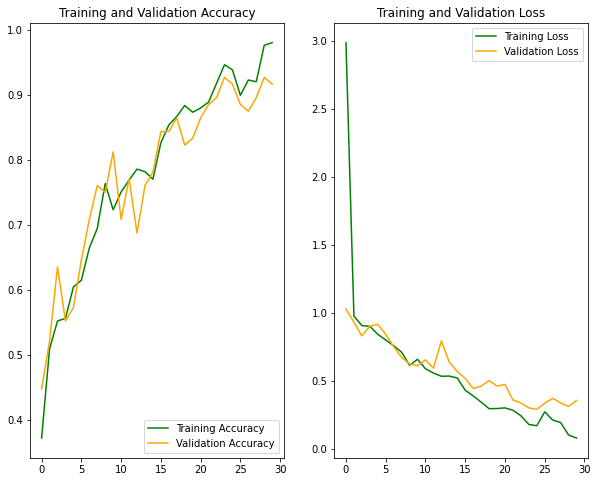

In [41]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, color='green', label='Training Accuracy')
plt.plot(range(30), val_acc, color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, color='green', label='Training Loss')
plt.plot(range(30), val_loss,color='orange', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h4 style="background-color:#1a4d08;color:white; padding:12px">5.5. MAKE PREDICTION ON TEST SET</h4>

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


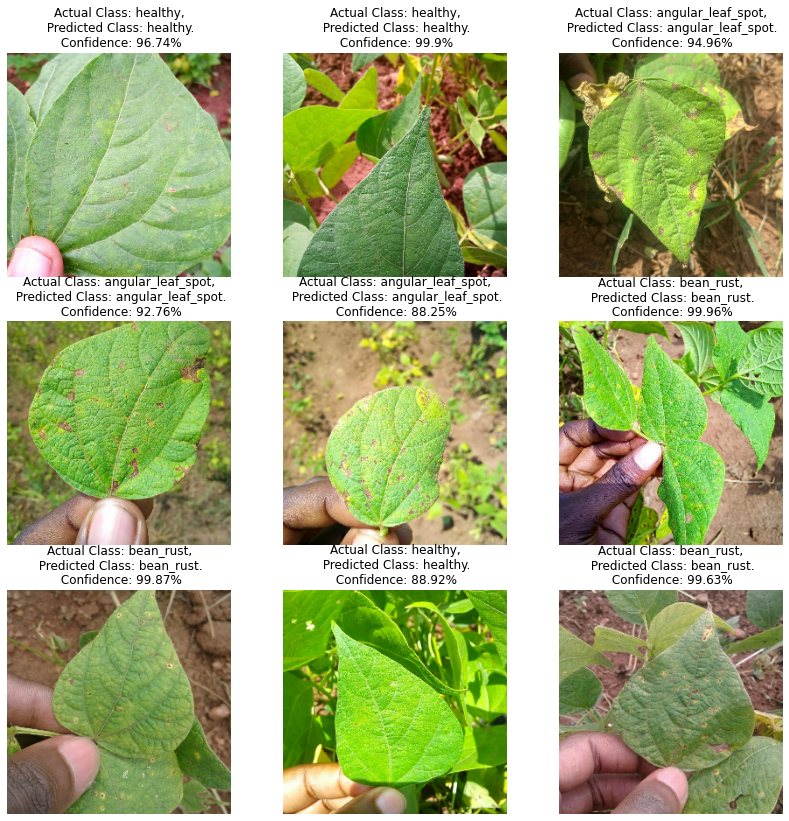

In [43]:
class_names = bean_classes

plt.figure(figsize=(14, 14))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual Class: {actual_class},\n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

# 6. Save Model

In [44]:
model.save(os.path.join('models', 'bean_disease_model.h5'))

# 7. Load Model and Predict

In [49]:
load_model = models.load_model('models/bean_disease_model.h5')
load_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)       

In [37]:
pwd

'/home/hadi/Desktop/BeanDiseaseClassification/BeanDiseaseClassification'

In [51]:
predict(load_model, "Bean_Dataset/bean_rust/bean_rust_08.jpg")

('bean_rust', 99.63)

(-0.5, 255.5, 255.5, -0.5)

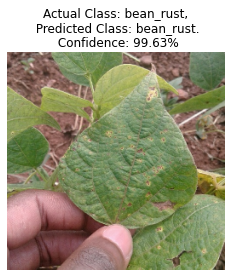

In [54]:
plt.imshow(images[i].numpy().astype("uint8"))
        
predicted_class, confidence = predict(load_model, "Bean_Dataset/bean_rust/bean_rust_08.jpg")
actual_class = "bean_rust" 
        
plt.title(f"Actual Class: {actual_class},\n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        
plt.axis("off")